## **II. Analysis**

*(approx. 2-4 pages)*

### **Data Exploration**

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:

* *If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?*

* *If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?*

* *If a dataset is not present for this problem, has discussion been made about the input space or input data for your problem?*

* *Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)*


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    nuclei_files = np.array(glob(path+'/*/images/*'))
    nuclei_targets = np.array(glob(path+'/*/masks/*'))
    return nuclei_files,nuclei_targets

    
def load_dataset_2(path):
    training_paths = pathlib.Path(path).glob('*/images/*.png')
    training_sorted = sorted([x for x in training_paths])
    im_path = training_sorted[45]
    im = imageio.imread(str(im_path))
    #nuclei_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return nuclei_files#, nuclei_target

train_files,train_targets = load_dataset('stage1_train/')
test_files,test_targets= load_dataset('stage1_test/')

#TODO: pick a better represntation of a validation set


print('There are %d training batch nuecli images.' % len(train_files))
print('There are %d training batch nuecli masks.' % len(train_targets))




Using TensorFlow backend.


There are 670 training batch nuecli images.
There are 29461 training batch nuecli masks.


In [22]:
# Binding masks with the parent image:
import os.path

def get_filename(path):
    return os.path.splitext(os.path.basename(path))[0]

def bind_mask_to_images(images_paths, masks_paths):
    image_id = 0
    filename = get_filename(images_paths[0])
    masks_binded = [[]]
    for mask_path in masks_paths:
        if filename in mask_path:
            masks_binded[image_id].append(mask_path)
        else:
            image_id = image_id+1
            filename = get_filename(images_paths[image_id])
            masks_binded.append([mask_path])
    return np.array(masks_binded)

def merge_masks(train_targets_binded):
    for binder in train_targets_binded:
        merged_mask = numpy.zeros_like(binder[0])
        for mask in binder:
              merged_mask = np.maximum(merged_mask,mask)
        binder = merged_mask
    return train_targets_binded
    
train_targets_binded = bind_mask_to_images(train_files,train_targets)
train_targets_merged = merge_masks(train_targets_binded)

print("Train targets have been binded and merged")

NameError: name 'numpy' is not defined

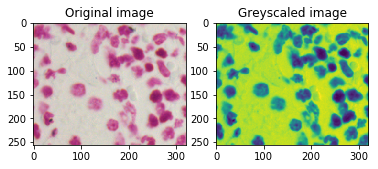

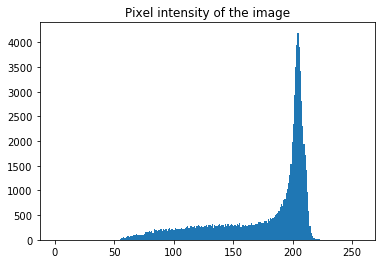

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# load color (BGR) image
img = cv2.imread(train_files[3])
# convert BGR image to grayscale
gray = cv2.imread(train_files[3],0)


#from skimage.color import rgb2gray
#im_gray = rgb2gray(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original image")
plt.subplot(1,2,2)
plt.title("Greyscaled image")
plt.imshow(gray)
plt.show()
#pixel intensity for image
plt.hist(gray.ravel(),256,[0,256])
plt.title("Pixel intensity of the image")
plt.show()


Code from: https://docs.opencv.org/3.1.0/d1/db7/tutorial_py_histogram_begins.html , https://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/ and dog-project

In [4]:
from sklearn.cluster import KMeans
import random

seed = random.seed(8675309)
def find_dominant_color_in_image(image,number_of_clusters):
    # re-shape our image to be a list of pixels, rather than MxN matrix of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    color_clf = KMeans(random_state=seed,n_clusters = number_of_clusters)
    color_clf.fit(image)
    
    return color_clf.cluster_centers_

def cluster_images_based_on_color(images_path_array,number_of_clusters,number_of_colors):
    dominant_colors = []
    for image_path in images_path_array:
        image = cv2.imread(image_path)
        colors_in_image = find_dominant_color_in_image(image,number_of_colors)
        dominant_colors.append(colors_in_image.flatten())
    #print(image)
    #print(dominant_colors)
    img_clf = KMeans(random_state=seed,n_clusters = number_of_clusters)
    img_clf.fit(np.array(dominant_colors))
    return img_clf

def plot_color_bar(colors):
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    for color in colors:
        #print ("color in bar",color)
        endX = startX + (1/len(colors) * 300)
        #print("the start is",startX, 'the end is',endX)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),color.astype("uint8").tolist(), -1)
        startX = endX
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    return bar





In [5]:
number_of_colors = 3
images_clf = cluster_images_based_on_color(train_files,7,number_of_colors)


670


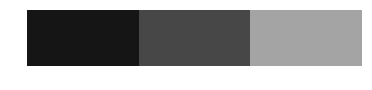

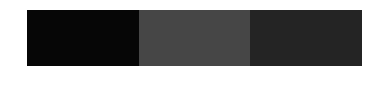

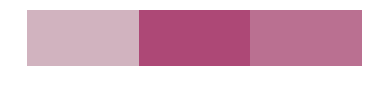

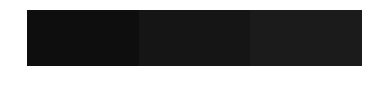

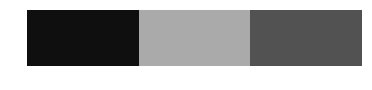

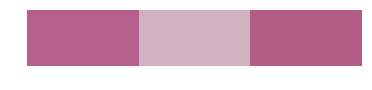

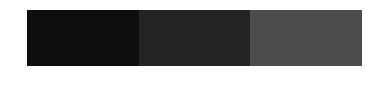

In [6]:
colors_clusters = images_clf.cluster_centers_
labels = images_clf.labels_
print(len(labels))
RGB_COLORS_CONSTANT = 3
if(number_of_colors>1):
    for color in colors_clusters:
        plot_color_bar(np.split(color,RGB_COLORS_CONSTANT))
else:
    for color in colors_clusters:
        plot_color_bar(color)

## Colors and Stains:

We can observe from the previous clusters that the dataset is stained differently, the differences in coloring. Hence, we'll be using grayscale?

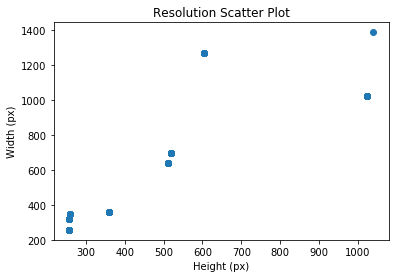

In [7]:
#print (images_clf)
sample_image = cv2.imread(train_files[0])
#print (sample_image.shape[1])
def get_images_features_list(images_path_array):
    images_height = []
    images_width = []
    images_mean = []
    images_std= []
    for image_path in images_path_array:
        image = cv2.imread(image_path)
        images_height.append(image.shape[0])
        images_width.append(image.shape[1])
        images_mean.append(np.mean(image))
        images_std.append(np.std(image))
    return images_height,images_width,images_mean,images_std

def plot_scatter_plot(X,y):
    plt.xlabel("Height (px)")
    plt.ylabel("Width (px)")
    plt.title("Resolution Scatter Plot")
    plt.scatter(X, y)
    
X,y,means,stdvs = get_images_features_list(train_files)
plot_scatter_plot(X,y)

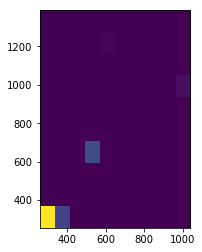

In [8]:
heatmap, xedges, yedges = np.histogram2d(X, y, bins=10)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

paired = (list(zip(X,y)))



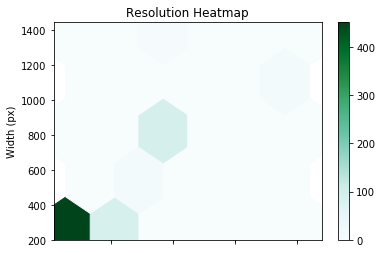

In [9]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data=paired)
#print(df.keys)
df.index.name = 'x label'

ax = df.plot.hexbin(x=0, y=1, gridsize=5,title="Resolution Heatmap",)
ax.set_ylabel("Width (px)")
ax.set_xlabel("Height (px)") #bug in juypter notebook doens't show the x-axis


In [10]:
from skimage import io, img_as_float
import numpy as np

image = io.imread('http://i.stack.imgur.com/Y8UeF.jpg')
image = img_as_float(image)
print(np.mean(image))

0.236323482353


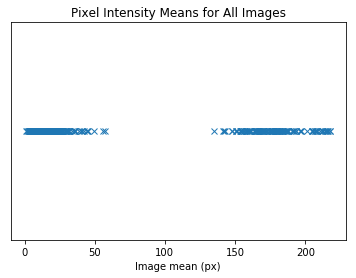

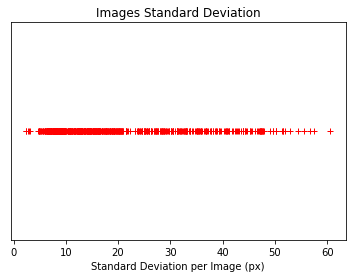

In [11]:
#Plot "Pixel Intensity Means for All Images" and "Standard Deviation per Image"

plt.plot(means, np.zeros_like(means), 'x')
plt.xlabel("Image mean (px)")
plt.title("Pixel Intensity Means for All Images")
plt.axes().get_yaxis().set_visible(False)
plt.show()
plt.plot(stdvs, np.zeros_like(stdvs), 'r+')
plt.title("Images Standard Deviation")
plt.axes().get_yaxis().set_visible(False)
plt.xlabel("Standard Deviation per Image (px)")
plt.show()

## Preprocessing:

In [12]:
#Taken from dog-project, Preprocessing for Keras
from keras.preprocessing import image                  
from tqdm import tqdm


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(150, 150))
    # convert PIL.Image.Image type to 3D tensor with shape (150, 150, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 150, 150, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras, since we need to match the pre-trained enviroment, we divide by 255
train_files_tensors = paths_to_tensor(train_files[:100]).astype('float32')/255 

train_target_tensors = paths_to_tensor(train_targets_merged[:100]).astype('float32')/255


100%|█████████████████████████████████████████| 2900/2900 [00:37<00:00, 77.67it/s]


In [14]:
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv2DTranspose
from keras.layers import Dropout, Flatten, Dense, Reshape
from keras.models import Sequential,Model

#TODO bottleneck_features
base_model = Xception(input_shape=train_files_tensors.shape[1:],weights='imagenet', include_top=False)

xc = base_model.output


In [15]:
from keras.layers import Conv2DTranspose
#xc = GlobalAveragePooling2D()(xc)
#xc = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same')(xc)
#output = Conv2D(1, (1, 1), activation='sigmoid') (xc)

#output = Dense(2, activation='sigmoid')(xc)

xc = base_model.output
#xc = GlobalAveragePooling2D()(xc)
output= Conv2DTranspose(3, (3, 3), strides=(30, 30),output padding='same',activation='relu')(xc)
#predictions = Dense(100, activation='softmax')(xc)

# add your top layer block to your base model
Xception_starter_model = Model(base_model.input, output)

# freeze Xception layers
for layer in Xception_starter_model.layers[:132]:
    layer.trainable = False

print(Xception_starter_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 74, 74, 32)    864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 74, 74, 32)    128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 74, 74, 32)    0                                            
___________________________________________________________________________________________

### Metric:

In [20]:
#Taken from https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277#295658

def meanIoU(y_true_batch, y_pred_batch):
    return np.mean(np.asarray([IoU(y_pred_batch, y_true_batch,t) for t in np.arange(0.5, 1, 0.05)])) 

def IoU(y_pred_batch, y_true_batch, threshold):
    print (y_true_batch)
    return np.mean(np.asarray([pixelAccuracy(y_pred_batch[i], y_true_batch[i],threshold) for i in range(len(y_true_batch))])) 

def pixelAccuracy(y_pred_orig, y_true, threshold):
    y_pred = (y_pred_orig > threshold)   
    return 1.0 * np.sum((y_pred==y_true)*(y_true>0)) /  (np.sum(y_pred>0) + np.sum(y_true>0) - np.sum((y_pred==y_true)*(y_true>0)))

### Compile:

In [21]:
Xception_starter_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=[meanIoU])


Tensor("conv2d_transpose_1_target_2:0", shape=(?, ?, ?, ?), dtype=float32)


TypeError: object of type 'Tensor' has no len()

In [ ]:
# taken from dog-project
from keras.callbacks import ModelCheckpoint  

epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.xception_starter.hdf5', 
                               verbose=1, save_best_only=True)

Xception_starter_model.fit(train_files_tensors, train_files_tensors, validation_split=0.1,
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)



In [ ]:
def Xception_detect_nuclei(img_path):
    # extract bottleneck features
    #bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_starter_model.predict(path_to_tensor(img_path))
    # return dog breed that is predicted by the model
    return predicted_vector


In [ ]:
print(train_files_tensors.shape[1:])
print(train_files_tensors[1].shape)
plt.imshow(train_files_tensors[1])
plt.show()
print(train_target_tensors[1].shape)
plt.imshow(train_target_tensors[10])

In [ ]:
## Sanity Check:
predImage = Xception_detect_nuclei(train_files[0])
print(predImage[0].shape)
#predImage = cv2.imread(pred)
plt.imshow(predImage[0])
